In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import os
import cv2
from tqdm import tqdm
from utils import get_2D_projections
from datetime import datetime
import traceback
from PIL import Image

%env SITK_SHOW_COMMAND '/home/andres/Downloads/Slicer-5.4.0-linux-amd64/Slicer'

env: SITK_SHOW_COMMAND='/home/andres/Downloads/Slicer-5.4.0-linux-amd64/Slicer'


In [2]:
import sys

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Utils import utils

In [3]:
config = utils.read_config()
config

{'common': {'paths': {'source_path_wd': 'E:/U-CAN-Lymfom_A',
   'source_path_bd': '/media/andres/T7 Shield/ucan_lymfom'}},
 'selection': {'filenames': {'rejected_folder_filename': 'Rejected_exams_from_U-CAN-Lymfom.xlsx',
   'sourcefiltered_folder_filename': 'SourceFiltered_exams_from_U-CAN-Lymfom.xlsx',
   'incomplete_folders_filename_initial': 'Excel_files/06_11_2023/No_PT_or_CT_exams_from_U-CAN-Lymfom_before_selection_process.xlsx',
   'incomplete_folders_filename_final': 'Excel_files/06_11_2023/No_PT_or_CT_exams_from_U-CAN-Lymfom_after_selection_process.xlsx',
   'selected_folders_beforefiltering_filename': 'Excel_files/06_11_2023/Selected_exams_after_filtering_from_U-CAN-Lymfom.xlsx',
   'selected_folders_afterfiltering_filename': 'Excel_files/06_11_2023/Selected_exams_before_filtering_from_U-CAN-Lymfom.xlsx',
   'final_selected_images_filename': 'Excel_files/06_11_2023/Final_Selected_exams_from_U-CAN-Lymfom.xlsx',
   'list_of_distorted_images_filename': 'Excel_files/06_11_2023/exa

In [5]:
source_path_wd = config['common']['paths']['source_path_wd']
source_path_bd = config['common']['paths']['source_path_bd']
final_selected_images_filename = config['metadata']['filenames']['final_selected_images_filename']
#projection_path = 'E:\\Sambit\\Project_10\\Data\\2D Projections\\' #config['projections']['paths']['destination_path']
projection_path = '/media/andres/T7 Shield1/UCAN_project/Resampled_Projections/'

selection_dataframe = os.path.join(source_path_wd, final_selected_images_filename)
final_projections = os.path.join(source_path_wd, projection_path)
final_projections

'/media/andres/T7 Shield1/UCAN_project/Resampled_Projections/'

In [6]:
selection_dataframe

'E:/U-CAN-Lymfom_A/Excel_files/06_11_2023/Finalized_dataset.xlsx'

In [7]:
projections = config['projections']
projections

{'paths': {'destination_path': 'Selected_for_UCAN_project/2dprojections'},
 'variables': {'modality': ['CT', 'PT', 'SUV'],
  'tissue_type': ['LT', 'AT', 'LT', 'B', 'N'],
  'projection_type': ['sum', 'min', 'max', 'mean', 'std'],
  'angles': [0, 90]}}

In [8]:
modality = projections['variables']['modality']
ttype = projections['variables']['tissue_type'][:-1]
ptype = projections['variables']['projection_type']
angles = projections['variables']['angles']

In [9]:
ttype

['LT', 'AT', 'LT', 'B']

In [10]:
config_size = config['resampling']['image_size']
config_spacing = config['resampling']['voxel_spacing']
print('config_size: ', config_size)
print('config_spacing: ', config_spacing)

config_size:  [256, 256, 256]
config_spacing:  [2.0364201068878174, 2.0364201068878174, 3.0]


In [14]:
#resampled_destination_path = 'E:/Sambit/Other_Projects/UCAN/Resampled_SUV_CT/'
#resampled_destination_path = 'E:/Sambit/Project_10/Data/Resampled_SUV_CT/'
resampled_destination_path = '/media/andres/T7 Shield1/UCAN_project/Resampled_SUV_CT/'
#resampled_destination_path = 'F:/ucan_lymfom/Resampled_SUV_CT/Sample31Oct2023/'

In [ ]:
resampled_directory_list = []

for dirs, subdirs, files in os.walk(resampled_destination_path):
    for file in files:
        file_path = str(os.path.join(dirs, file))
        file_path = file_path.replace('\\','/')
        resampled_directory_list.append(file_path)
        print(file_path)

In [ ]:
resampled_directory_df = pd.DataFrame(resampled_directory_list, columns=['directory'])
resampled_directory_df[['source_directory', 'patient_directory', 'scan_date', 'SUV_CT']] = resampled_directory_df['directory'].str.rsplit(pat='/', n=3, expand=True)
resampled_directory_df[['npr', 'extra']] = resampled_directory_df['patient_directory'].str.split(pat='_', n=1, expand=True)
resampled_directory_df.drop(columns=['directory','extra', 'SUV_CT'], inplace=True)
resampled_directory_df.drop_duplicates(inplace=True)

resampled_directory_df.head()

In [ ]:
resampled_directory_df.shape

In [ ]:
resampled_directory_df.columns

In [ ]:
for index, row in resampled_directory_df.iterrows():

    CT_ptype = 'mean'
    SUV_ptype = 'max'
    angle = 90
    
    for mod in ['CT','SUV']:
        for item in ['MIP', 'bone', 'lean', 'adipose', 'air']:
            dir_path = projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/' + mod + '_' + item
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

    
    CTnii_path = resampled_destination_path + str(row['npr']) + '_SUV_CT/' + str(row['scan_date']) + '/' + 'CT.nii.gz'
    SUVnii_path = resampled_destination_path + str(row['npr']) + '_SUV_CT/' + str(row['scan_date']) + '/' + 'SUV.nii.gz'

    CT_img =sitk.ReadImage(CTnii_path)
    SUV_img =sitk.ReadImage(SUVnii_path)

    bone_mask, lean_mask, adipose_mask, air_mask = utils.get_proj_after_mask(CT_img)

    multiply= sitk.MultiplyImageFilter()

    CT_bone = multiply.Execute(CT_img,sitk.Cast(bone_mask,CT_img.GetPixelID()))
    CT_lean = multiply.Execute(CT_img,sitk.Cast(lean_mask,CT_img.GetPixelID()))
    CT_adipose = multiply.Execute(CT_img,sitk.Cast(adipose_mask,CT_img.GetPixelID()))
    CT_air = multiply.Execute(CT_img,sitk.Cast(air_mask,CT_img.GetPixelID()))

    utils.get_2D_projections(CT_img, 'CT', CT_ptype, angle, invert_intensity= False, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_MIP/')
    utils.get_2D_projections(CT_bone, 'CT', CT_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_bone/')
    utils.get_2D_projections(CT_lean, 'CT', CT_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_lean/')
    utils.get_2D_projections(CT_adipose, 'CT', CT_ptype, angle, invert_intensity= False, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_adipose/')
    utils.get_2D_projections(CT_air, 'CT', CT_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/CT_air/')
    
    SUV_bone = multiply.Execute(SUV_img,sitk.Cast(bone_mask,SUV_img.GetPixelID()))
    SUV_lean = multiply.Execute(SUV_img,sitk.Cast(lean_mask,SUV_img.GetPixelID()))
    SUV_adipose = multiply.Execute(SUV_img,sitk.Cast(adipose_mask,SUV_img.GetPixelID()))
    SUV_air = multiply.Execute(SUV_img,sitk.Cast(air_mask,SUV_img.GetPixelID()))

    utils.get_2D_projections(SUV_img, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_MIP/')
    utils.get_2D_projections(SUV_bone, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_bone/')
    utils.get_2D_projections(SUV_lean, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_lean/')
    utils.get_2D_projections(SUV_adipose, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_adipose/')
    utils.get_2D_projections(SUV_air, 'SUV', SUV_ptype, angle, img_n=projection_path + str(row['npr']) + '/' + str(row['scan_date']) + '/SUV_air/')


### Testing projections

folder structure: patient / scandate / CT_tissuetype/angle.npy

In [8]:
file_path = r'/media/andres/T7 Shield1/UCAN_project/Resampled_Projections/npr209568543213/20180703'
angles = ["-90.0.npy", "0.0.npy"]
image_visualization = ["CT_MIP", "SUV_MIP", "CT_bone", "SUV_bone", "CT_lean", "SUV_lean", "CT_adipose", "SUV_adipose", "CT_air", "SUV_air"]

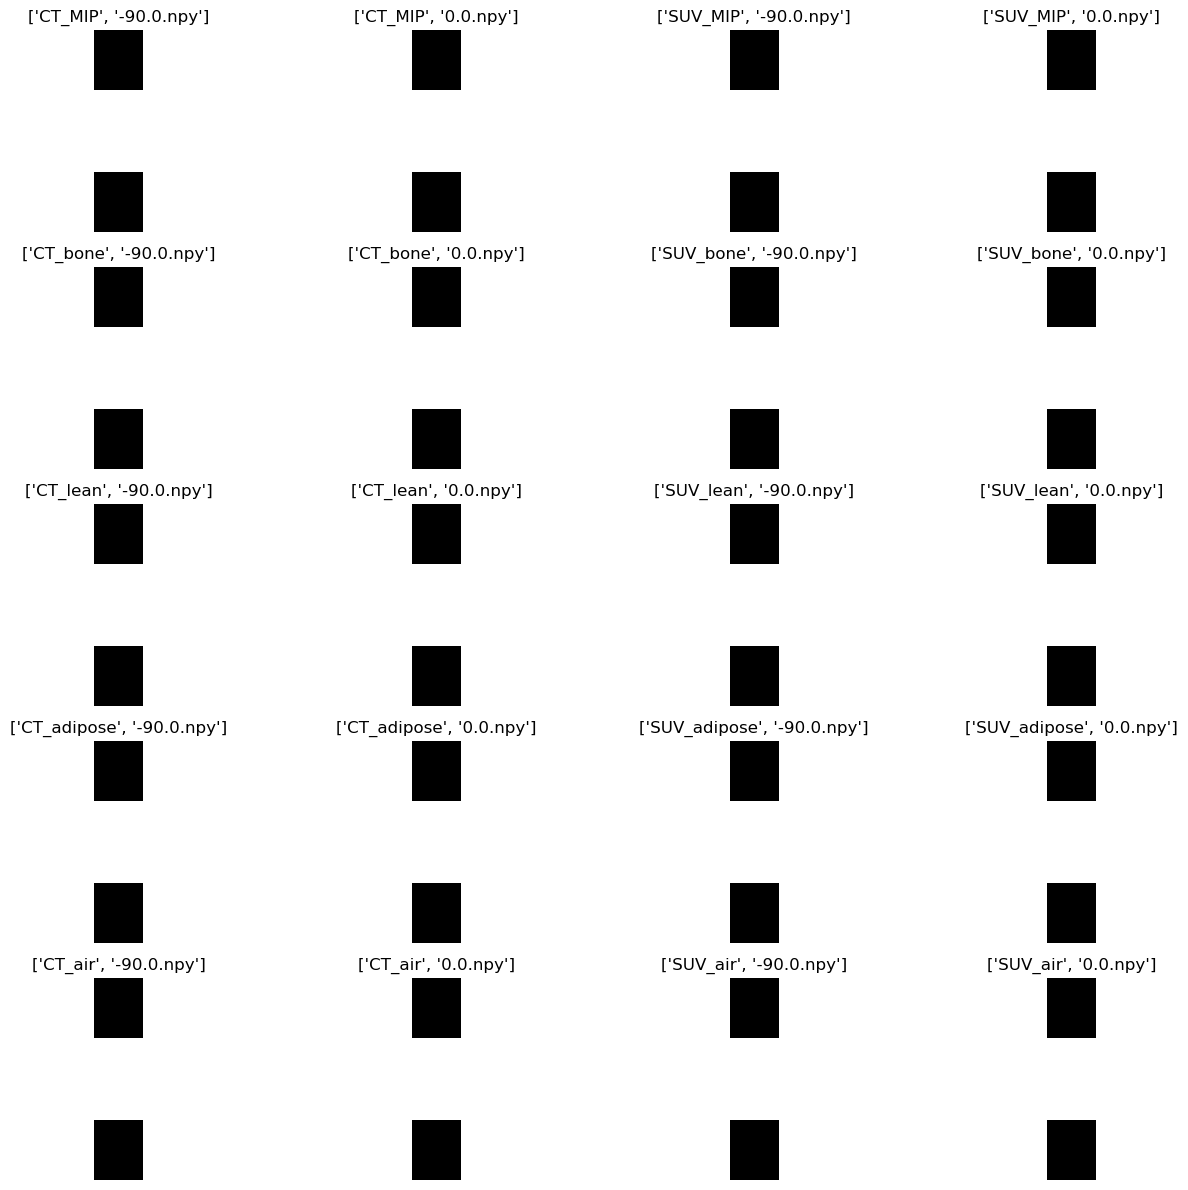

In [9]:
ax = []
images_for_plot = []
for type in image_visualization:
    for angle in angles:
        path_extension = type + "/" + angle
        image_path = os.path.join(file_path, path_extension)
        images_for_plot.append(image_path)

fig, axes = plt.subplots(5, 4, figsize=(15, 12))
axes = axes.flatten()

for i, image_path in enumerate(images_for_plot):
    image = np.load(image_path)
    axes[i].imshow(image, cmap="gray")

    axes[i].set_title(image_path.split("/")[-2:])

    axes[i].axis("off")

plt.tight_layout()
plt.show()

##### Generate a dataframe with the nifti files path, patiend ID and scan date

In [132]:
from os import listdir

projections = r'/media/andres/T7 Shield1/UCAN_project/Resampled_SUV_CT/'
nifti_df = pd.DataFrame(columns=["patient_ID", "scan_date", "nifti_path"])
for patient_ID in tqdm(sorted(os.listdir(projections))):
    for scan_date in sorted(listdir(os.path.join(projections, patient_ID))):
        patient_path = os.path.join(projections, patient_ID)
        for scan_type in listdir(os.path.join(patient_path, scan_date)):
            scan_path = os.path.join(patient_path, scan_date)
            df_temp = pd.DataFrame({"patient_ID": [patient_ID.split("_")[0]], "scan_date": [scan_date], "nifti_path": [os.path.join(scan_path, scan_type)]})
            nifti_df = pd.concat([nifti_df, df_temp], ignore_index=True)

100%|██████████| 1076/1076 [00:01<00:00, 624.16it/s]


In [133]:
nifti_df.to_excel("/media/andres/T7 Shield1/UCAN_project/nifti_dataframe.xlsx")

## TESTING

In [10]:

def save_projections_as_png(image,img_name, invert = True):
    '''

    Function to save 2d simpleitk projection objects as uint8 png images

    '''

    writer = sitk.ImageFileWriter()
    #img=sitk.Extract(image, image.GetSize())
    writer.SetFileName(img_name)
    # img_write=  sitk.Cast(    
    #     sitk.IntensityWindowing(
    #         image, windowMinimum=float(sitk.GetArrayFromImage(image).min()), windowMaximum=clip_value, outputMinimum=0.0, outputMaximum=255
    #     ),
    #     image.GetPixelID(),
    #     )
    img_write= sitk.Flip(image, [False, True]) #flipping across y axis
    img_write=sitk.Cast(
        sitk.RescaleIntensity(img_write), #sitk.RescaleIntensity()
        sitk.sitkUInt8
    )
    if invert:
        img_write   = sitk.InvertIntensity(img_write,maximum=255)
    else:
        pass
    writer.Execute(img_write)  #sitk.Cast(sitk.RescaleIntensity(img,outputMinimum=0,outputMaximum=15)



def save_projections_as_nparr(image,img_name, invert = True):
    '''

    Function to save 2d simpleitk projection images as a numpy array

    '''

    img = sitk.Flip(image, [False, True])

    if invert:
        img= sitk.InvertIntensity(img,maximum=255)
    else:
        pass
    
    arr= sitk.GetArrayFromImage(img)

    # Perform min-max normalization

    minv,maxv= np.min(arr), np.max(arr)
    arr_normed = (arr - minv) / (maxv - minv)
    np.save(img_name,np.array(arr_normed))


def get_2D_projections(vol_img,modality,ptype,angle,invert_intensity = True, clip_value=15.0, t_type='N',save_img=True,img_n=''):
    projection = {'sum': sitk.SumProjection,
                'mean':  sitk.MeanProjection,
                'std': sitk.StandardDeviationProjection,
                'min': sitk.MinimumProjection,
                'max': sitk.MaximumProjection}
    
    #vol_img = make_isotropic(vol_img)

    paxis = 0
    rotation_axis = [0,0,1]
    rotation_angles = np.linspace(-np.pi/2, np.pi/2, int( (np.pi / (  ( angle / 180 ) * np.pi ) ) + 1 ) ) # angle range- [0, +180];
    rotation_center = vol_img.TransformContinuousIndexToPhysicalPoint(np.array(vol_img.GetSize())/2.0) #[(index-1)/2.0 for index in vol_img.GetSize()])

    rotation_transform = sitk.VersorRigid3DTransform()
    #rotation_transform = sitk.Euler3DTransform()
    rotation_transform.SetCenter(rotation_center)

    #Compute bounding box of rotating volume and the resampling grid structure
    image_indexes = list(zip([0,0,0], [sz-1 for sz in vol_img.GetSize()]))
    image_bounds = []
    for i in image_indexes[0]:
        for j in image_indexes[1]:
            for k in image_indexes[2]:
                image_bounds.append(vol_img.TransformIndexToPhysicalPoint([i,j,k]))

    all_points = []
    for ang in rotation_angles:
        rotation_transform.SetRotation(rotation_axis, ang)    
        #rotation_transform.SetRotation(0,0,ang)    
        all_points.extend([rotation_transform.TransformPoint(pnt) for pnt in image_bounds])
        
    all_points = np.array(all_points)
    min_bounds = all_points.min(0)
    max_bounds = all_points.max(0)


    #resampling grid will be isotropic so no matter which direction we project to
    #the images we save will always be isotropic (required for vol_img formats that 
    #assume isotropy - jpg,png,tiff...)

    new_spc = [np.min(vol_img.GetSpacing())]*3
    new_sz = [int(sz/spc + 0.5) for spc,sz in zip(new_spc, max_bounds-min_bounds)]
    # print('new size: ', new_sz)
    #new_sz = vol_img.GetSize()
    pix_array=sitk.GetArrayFromImage(vol_img)
    maxtensity,mintensity=float(pix_array.max()),float(pix_array.min())
    # print(maxtensity,mintensity)
    if modality == 'CT':
        default_pix_val=20


    else:
        default_pix_val=0
        #clipping intensities
        clamper = sitk.ClampImageFilter()
        clamper.SetLowerBound(0)
        clamper.SetUpperBound(clip_value)
        vol_img=clamper.Execute(vol_img)
        # vol_img = sitk.Cast(    
        # sitk.IntensityWindowing(
        #     vol_img, windowMinimum=mintensity, windowMaximum=clip_value, outputMinimum=0.0, outputMaximum=255
        # ),
        # vol_img.GetPixelID(),
        # )

    for ang in rotation_angles:
        rotation_transform.SetRotation(rotation_axis, ang) 
        #rotation_transform.SetRotation(0,0,ang)
        resampled_image = sitk.Resample(image1=vol_img,
                                        size=new_sz,
                                        transform=rotation_transform,
                                        interpolator=sitk.sitkNearestNeighbor,
                                        outputOrigin=min_bounds,
                                        outputSpacing=new_spc,
                                        outputDirection = vol_img.GetDirection(), #[1,0,0,0,1,0,0,0,1]
                                        defaultPixelValue = default_pix_val, 
                                        outputPixelType = vol_img.GetPixelID())
        """
        if modality=='CT':
            masked_resampled_image=get_proj_after_mask(resampled_image,maxtensity,mintensity,t_type)
        else:
            masked_resampled_image=resampled_image
        """

        proj_image = projection[ptype](resampled_image, paxis)
        extract_size = list(proj_image.GetSize())
        extract_size[paxis]=0 
        axes_shifted_pi=sitk.Extract(proj_image, extract_size) #flip axes

        if save_img:
            imgname= img_n + r'{0}'.format((180 * ang/np.pi))
            save_projections_as_png(axes_shifted_pi, imgname + '.png', invert_intensity) #sitk.InvertIntensity(axes_shifted_pi,maximum=1)
            save_projections_as_nparr(axes_shifted_pi, imgname, invert_intensity)
    print(f'Finished generating {int(180.0/angle)+1} - {ptype} intensity 2D projections from the {modality} volume image! ')

In [ ]:
file_path = r'/media/andres/T7 Shield1/UCAN_project/Resampled_Projections/npr209568543213/20180703'
angles = ["-90.0.npy", "0.0.npy"]
image_visualization = ["CT_MIP", "SUV_MIP", "CT_bone", "SUV_bone", "CT_lean", "SUV_lean", "CT_adipose", "SUV_adipose", "CT_air", "SUV_air"]

In [ ]:
ax = []
images_for_plot = []
for type in image_visualization:
    for angle in angles:
        path_extension = type + "/" + angle
        image_path = os.path.join(file_path, path_extension)
        images_for_plot.append(image_path)

fig, axes = plt.subplots(5, 4, figsize=(15, 12))
axes = axes.flatten()

for i, image_path in enumerate(images_for_plot):
    image = np.load(image_path)
    axes[i].imshow(image, cmap="gray")

    axes[i].set_title(image_path.split("/")[-2:])

    axes[i].axis("off")

plt.tight_layout()
plt.show()